In [1]:
import sys

sys.path.append("../src")

In [2]:
import json

from data_processing.video import plot_frame
from feature_extraction.webcam import *
from utils import Paths

In [3]:
paths = Paths("../configs/paths.json")

# Load Feature Extraction Module

In [5]:
n_expression = 8
feature_extractor = WebcamFeatureExtractionModule(
    emonet_path=paths[f"EmoNet-{n_expression}"],
    sixdrepnet_path=paths["SixDRepNet"],
    n_expression=n_expression,
)

print(f"Using: {feature_extractor.device}")

Using: cuda


In [6]:
if str(feature_extractor.device) == "cuda":
    torch.cuda.empty_cache()
    print("Cleared CUDA cache")

Cleared CUDA cache


## Load sample clip

In [7]:
device = feature_extractor.device
frames = parse_video(paths["SampleClip"].as_posix(), sample_rate=15).to(device)
frames.shape

torch.Size([44, 3, 256, 256])

In [8]:
with torch.no_grad():
    out = feature_extractor.emonet(frames)
embeddings = out["embedding"]
heatmaps = out["heatmap"]
print(f"Embedding Size:", " x ".join([str(i) for i in embeddings.shape]))
print(f"Heatmap Size:", " x ".join([str(i) for i in heatmaps.shape]))

Embedding Size: 44 x 256
Heatmap Size: 44 x 68 x 64 x 64


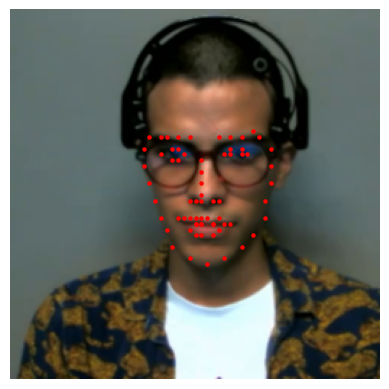

In [9]:
frame_img = pillowfy_frames(frames)[0]
landmarks = get_landmarks_from_heatmap(heatmaps[0].cpu(), frames.shape[2:])
# Plot the image
plt.imshow(frame_img)

# Plot the landmarks on top of the image
plt.scatter(landmarks[:, 0], landmarks[:, 1], c="r", marker="o", s=5)
plt.axis("off");

## Head Pose Estimation

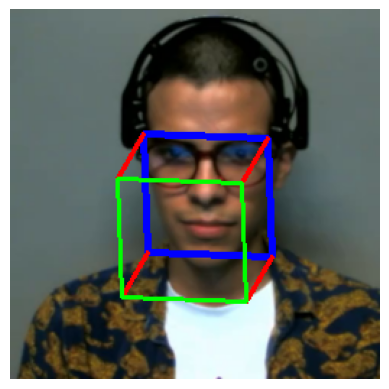

In [10]:
pose_model = feature_extractor.pose_model
rotations = pose_model.predict_rotation(frames)
result = pose_model._plot_pose_cube(frame_img, rotations[0] * 180 / np.pi, landmarks)
plot_frame(result)

## Extracting face mask

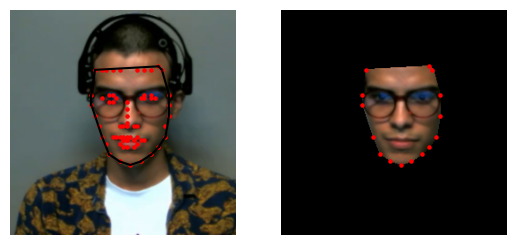

In [11]:
landmarks_with_margin = add_forehead_margin(landmarks)
face = crop_face_with_landmarks(frame_img, landmarks_with_margin);

# Cropping bounding square box

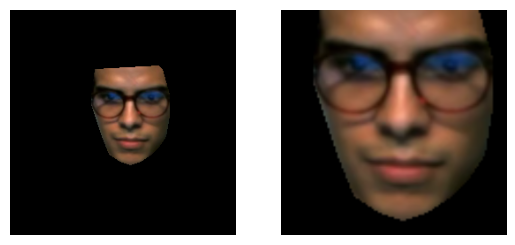

In [12]:
box = get_bounding_box(landmarks_with_margin, margin=0, nose_center=True)
cropped_face = crop_bounding_box(face, box)
fig, axs = plt.subplots(ncols=2)
axs[0].imshow(face)
axs[1].imshow(cropped_face)
axs[0].axis("off")
axs[1].axis("off");

# Streamlining the feature extraction process
## Test with a batch of frames

face: 0it [00:00, ?it/s]

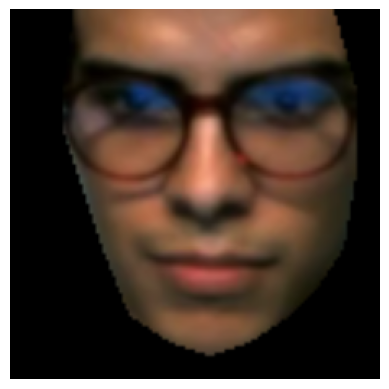

In [13]:
result = feature_extractor.process_frames_batch(frames)
plt.imshow(result[0][0])
plt.axis("off");

## Automate the processing of the entire dataset

In [14]:
def process_data(input_root, output_root, mirror=False, n_jobs=4):
    out_root = os.path.join(output_root, "FaceMasks")
    emb_out_root = os.path.join(output_root, "Features")
    for p in tqdm(os.listdir(input_root), desc="Users"):
        p_dir = os.path.join(input_root, p)
        out_dir = os.path.join(out_root, p)
        emb_out_dir = os.path.join(emb_out_root, p)
        if not os.path.isdir(out_dir):
            os.makedirs(out_dir)
        if not os.path.isdir(emb_out_dir):
            os.makedirs(emb_out_dir)

        def step(filename):
            if not filename.endswith(".mp4"):
                return
            out_path = os.path.join(out_dir, filename)
            emb_out_path = os.path.join(emb_out_dir, filename.replace(".mp4", ""))
            if os.path.isfile(f"{emb_out_path}.npz") and os.path.isfile(out_path):
                return

            video_path = os.path.join(p_dir, filename)
            faces, features, pose, landmarks, frame_indices = process_video(
                video_path, mirror=mirror
            )
            save_into_file(faces, out_path)
            np.savez(
                emb_out_path,
                frame_indicex=frame_indices,
                embedding=features[:, :-10],
                expression=features[:, -10:-2],
                valence_arousal=features[:, -2:],
                landmarks=landmarks,
                pose=pose,
            )
            del faces, features, pose, landmarks
            gc.collect()

        if n_jobs is not None and n_jobs > 1:
            Parallel(n_jobs=n_jobs, backend="threading")(
                delayed(step)(filename)
                for filename in tqdm(os.listdir(p_dir), desc=p, leave=False)
            )
        else:
            for filename in tqdm(os.listdir(p_dir), desc=p, leave=False):
                step(filename)

In [ ]:
process_data(input_root=paths["Videos"], output_root=paths["ProcessedVideos"], n_jobs=1)

## Mirrored version for data augmentation

In [ ]:
process_data(
    input_root=paths["Videos"],
    output_root=os.path.join(paths["ProcessedVideos"], "Mirrored"),
    mirror=True,
    n_jobs=1,
)